In [1]:
import importlib
modules = ["maxent", "optimizer", "plot", "solver", "limiirl", "utils"]
def load_modules(modules): 
    for module in modules:
        imported_module = importlib.import_module(module)
        importlib.reload(imported_module)


load_modules(modules)

In [3]:
import pandas as pd 
import numpy as np 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from maxent import irl, irl_causal, feature_expectation_from_trajectories
import optimizer as O 
import solver as S                          # MDP solver (value-iteration)
import plot as P
from sklearn.preprocessing import OneHotEncoder
from limiirl import limiirl, phi, find_policy
from utils import *
from scipy.stats import wasserstein_distance

In [4]:
M = read_json("data/process/M.json")
M = np.array(M)

In [5]:
trajectories = read_json("data/process/trajs.json")
trajectories = { int(k) : v for k, v in zip(trajectories.keys(), trajectories.values()) }

In [6]:
def convert_traj(trajectories):
    lst = []
    for patient in trajectories:
        traj = trajectories[patient]
        row = []
        n = len(traj)
        for i in range(0, n-2, 2):
            row.append((traj[i], traj[i+1], traj[i+2]))
        
        lst.append(row)
    
    return lst

In [7]:
states = 100 
actions = 5 
discount = 0.9 
T = convert_traj(trajectories)

In [8]:
def calc_tran_model(taus, states=100, smoothing_value=1): 
    p_transition = np.zeros((states, states, actions)) + smoothing_value

    for traj in taus:
        for tran in traj:

            p_transition[tran[0], tran[2], tran[1]] +=1

        p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

    return p_transition

def calc_terminal_states(taus): 
    terminal_states = set() 

    for patient in taus: 
        terminal_states.add(taus[patient][-1])
    
    return list(terminal_states)


In [9]:
# Convert states and actions to one-hot encoding
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(states)])

In [10]:
# calculate starting state probabilities 
def calc_start_dist(taus, S): 
    X = np.zeros(S)
    n = len(taus)

    for tau in taus: 
        X[tau[0]] += 1 

    return X / n 

In [11]:
p_0 = calc_start_dist(list(trajectories.values()), states)
terminal_states = calc_terminal_states(trajectories)
p_transition = calc_tran_model(T, states=states)
features = state_encoder.fit_transform(np.arange(states).reshape(-1, 1))


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
def train_single_intent(): 
    # set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
    # choose our parameter initialization strategy:
    #   initialize parameters with constant
    init = O.Constant(1.0)

    # choose our optimization strategy:
    #   we select exponentiated stochastic gradient descent with linear learning-rate decay
    optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

    # actually do some inverse reinforcement learning
    # reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

    reward_maxent_causal, theta_causal = irl_causal(p_transition, features, terminal_states, T, optim, init, discount,
                eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)
    
    return reward_maxent_causal, theta_causal

In [13]:
reward_single, theta_single = train_single_intent()

In [14]:
_, soft_pi = find_policy(p_transition, reward_single, states)

In [15]:
import random 

n_patients = 500 
K = 25
gamma = 0.9


random_patients = random.sample(list(trajectories.keys()), n_patients)

trajectories_s = { patient: trajectories[patient] for patient in random_patients }

In [16]:
f = feature_expectation_from_trajectories(features, T)

In [17]:
def feature_trajectories(taus, gamma=0.9): 
    """ 
    taus: dictionary of the form { patient: tau } where tau is the patient's trajectory 
    during stay in ICU (from MIMIC dataset)

    gamma: discount factor 

    returns X of shape N x d, where N is the number of trajectories and d represents number of features 
    """
    X = [] 

    for patient in taus: 
        traj = taus[patient] 
        phi_t = phi(traj, f, gamma)
        X.append([phi_t])

    return np.array(X)    

In [18]:
X = feature_trajectories(trajectories_s)

In [19]:
def cluster_trajectories(X, n_experts=100): 
    """
    X: feature representation of trajectories
    n_experts: assume trajectories come from `n_experts` experts 

    performs kmeans clustering on X and returns model 
    """
    kmeans = KMeans(n_clusters=n_experts, random_state=42).fit(X)

    return kmeans 

In [184]:
cluster_model = cluster_trajectories(X, n_experts=K)

/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [186]:
max_iterations = 10
taus = list(trajectories_s.values())
epsilon = 0.005

In [ ]:
rho, theta, u = limiirl(X, taus, features, cluster_model, states, f=f, p_transition=p_transition, p_0=p_0,  transition=p_transition, max_iter=30, K=K, descent_iter=10)

In [246]:
with np.load('data/experiments/trial_1701044578.786054.npz') as data:
    rho = data['rho']
    u = data['u']
    theta = data['theta']

In [247]:
soft_experts = [find_policy(p_transition, features.dot(th), states)[1] for th in theta]
_, soft_single = find_policy(p_transition, features.dot(theta_single), states)

In [20]:
def sample_policy(pi, state, N=1000): 
    dist = pi[state]

    actions = np.arange(len(dist))
    sampled_actions = np.random.choice(actions, size=N, p=dist)

    return sampled_actions  

def policy_dist(pi_one, pi_two):
    # soft policies - distribution of actions for each state 

    dist_vect = [] 
    for s in range(states): 
        sample_one = sample_policy(pi_one, s)
        sample_two = sample_policy(pi_two, s)
        dist_vect.append(wasserstein_distance(sample_one, sample_two)) 

    
    return np.mean(dist_vect)

def cmp_single(expert_policies, single_policy): 
    """
    expert_policies: arr of policies of shape K x |S| x |A|  
    single_policy: policy of shape |S| x |A| 
    returns a vector of distances comparing kth expert with single intention model
    """

    dist_vect = [] 
    for expert_pi in expert_policies: 
        dist = policy_dist(expert_pi, single_policy)
        dist_vect.append(dist)

    return np.array(dist_vect)

In [249]:
dist_from_single = cmp_single(soft_experts, soft_single)

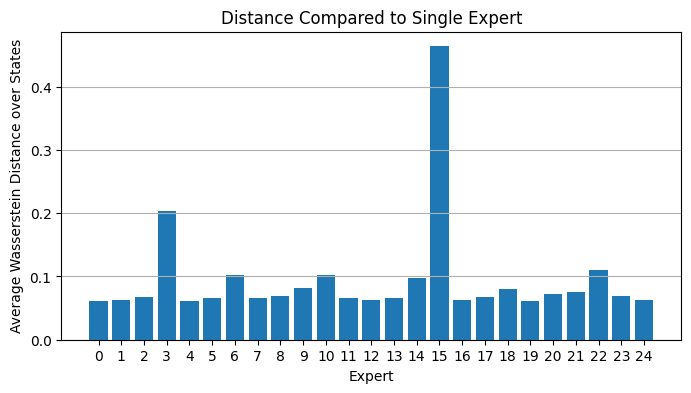

In [250]:
indices = np.arange(len(dist_from_single))

# Creating a bar plot
plt.figure(figsize=(8, 4))
plt.bar(indices, dist_from_single)
plt.xlabel('Expert')
plt.ylabel('Average Wasserstein Distance over States')
plt.title('Distance Compared to Single Expert')
plt.xticks(indices)  # To show each index on the x-axis
plt.grid(axis='y')   # Grid lines for y-axis only
plt.show()

In [21]:
import os 

def plot_dist(dir_name): 
    for root, dirs, files in os.walk(dir_name):
        for file in files: 
            with np.load(os.path.join(root, file)) as data:
                rho = data['rho']
                u = data['u']
                theta = data['theta']


                soft_experts = [find_policy(p_transition, features.dot(th), states)[1] for th in theta]
                _, soft_single = find_policy(p_transition, features.dot(theta_single), states)    

                dist_from_single = cmp_single(soft_experts, soft_single)  


                indices = np.arange(len(dist_from_single))

                # Creating a bar plot
                plt.figure(figsize=(8, 4))
                plt.bar(indices, dist_from_single)
                plt.xlabel('Expert')
                plt.ylabel('Average Wasserstein Distance over States')
                plt.title('Distance Compared to Single Expert')
                plt.xticks(indices)  # To show each index on the x-axis
                plt.grid(axis='y')   # Grid lines for y-axis only
                plt.show()
            

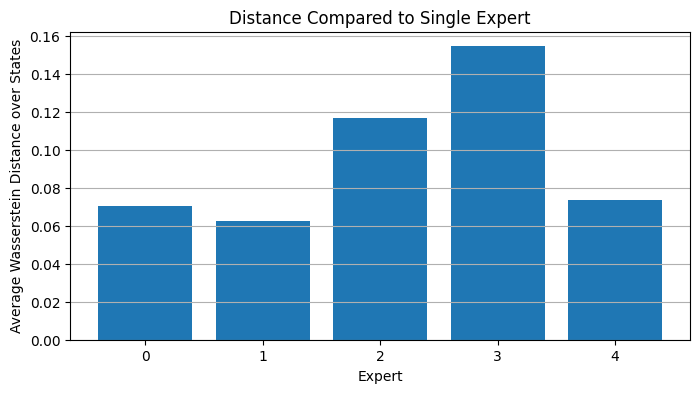

In [22]:
plot_dist("data/experiments/")